##### U-Net architecture

See [here](https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py#L19) for code and [here](https://arxiv.org/pdf/1505.04597.pdf) for the original literature.

In [16]:
# from __future__ import print_function # presumably for compatibility with python 2?

import cv2
import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Cropping2D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras import backend as K
K.set_image_dim_ordering('th')  # Theano dimension ordering in this code

import pickle
from matplotlib import pyplot as plt

# from data import load_train_data, load_test_data # These must be custom functions

In [17]:
# Load the components of the pushbullet API

from pushbullet import Pushbullet
with open('../pushbullet.api','r') as f:
    api = f.readline().strip()   
pb = Pushbullet(api)
phone = pb.devices[0]

In [18]:
# Run this cell after anything you want to be notified about!
def push(title='Done!',text='Whatever it was, it\'s done'):
    phone.push_note(title,text)

In [19]:
# Import the training data

load_whitened = True
if load_whitened:
    with open('./data/x_whitened_resized_array.pickle','rb') as f:
        x = pickle.load(f)
else:
    with open('./data/x_resized_array.pickle','rb') as f:
        x = pickle.load(f)
        # Normalize data to max values
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                x[i,j,:,:] *= 1/x[i,j,:,:].max()
                
with open('./data/y_resized_raster.pickle','rb') as f:
    y = pickle.load(f)

# Just use a single class: roads
#y = y[:,4,:,:]
#y = y[:,np.newaxis,:,:]

# y = y.reshape(y.shape[0],-1)
# x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, random_state=42)

In [20]:
# Normalize values between 1 and 0
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        x[i,j,:,:] /= x[i,j,:,:].max()
        #x[i,j,:,:] = (x[i,j,:,:].min() - x[i,j,:,:])/(x[i,j,:,:].min() - x[i,j,:,:].max())

In [21]:
def other_jaccard(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) - intersection + smooth)

    
other_jaccard(y[:,3,:,:],np.zeros((25,1,136,136)))

1.9654474341083747e-05

In [22]:
img_rows = x.shape[2] # 64 originally, now 136
img_cols = x.shape[3] # 80 originally, now 136

smooth = 1.

classType = 3

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jaccard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

def jaccard_loss(y_true, y_pred):
    return -jaccard(y_true, y_pred)

init = 'he_normal'
activation = 'relu'
nfilters = 32

early_stopping = EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=1, mode='auto')

def get_unet(lr,decay):
    
    inputs = Input((3, img_rows, img_cols))
    padded = ZeroPadding2D(padding=(28,28))(inputs)
    conv1 = Convolution2D(nfilters, 3, 3, activation=activation, border_mode='same',init=init)(padded)
    conv1 = Convolution2D(nfilters, 3, 3, activation=activation, border_mode='same',init=init)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(nfilters*2, 3, 3, activation=activation, border_mode='same',init=init)(pool1)
    conv2 = Convolution2D(nfilters*2, 3, 3, activation=activation, border_mode='same',init=init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(nfilters*4, 3, 3, activation=activation, border_mode='same',init=init)(pool2)
    conv3 = Convolution2D(nfilters*4, 3, 3, activation=activation, border_mode='same',init=init)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(nfilters*8, 3, 3, activation=activation, border_mode='same',init=init)(pool3)
    conv4 = Convolution2D(nfilters*8, 3, 3, activation=activation, border_mode='same',init=init)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(nfilters*16, 3, 3, activation=activation, border_mode='same',init=init)(pool4)
    conv5 = Convolution2D(nfilters*16, 3, 3, activation=activation, border_mode='same',init=init)(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(nfilters*8, 3, 3, activation=activation, border_mode='same',init=init)(up6)
    conv6 = Convolution2D(nfilters*8, 3, 3, activation=activation, border_mode='same',init=init)(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(nfilters*4, 3, 3, activation=activation, border_mode='same',init=init)(up7)
    conv7 = Convolution2D(nfilters*4, 3, 3, activation=activation, border_mode='same',init=init)(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(nfilters*2, 3, 3, activation=activation, border_mode='same',init=init)(up8)
    conv8 = Convolution2D(nfilters*2, 3, 3, activation=activation, border_mode='same',init=init)(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(nfilters, 3, 3, activation=activation, border_mode='same',init=init)(up9)
    conv9 = Convolution2D(nfilters, 3, 3, activation=activation, border_mode='same',init=init)(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid',init=init)(conv9)
    cropped = Cropping2D(cropping=((28,28), (28,28)))(conv10)

    model = Model(input=inputs, output=cropped)
    model.compile(optimizer=Adam(lr=lr,decay=decay), loss=jaccard_loss, metrics=[jaccard])

    return model

#model = get_unet()
#model.summary()

In [23]:
def train_and_predict():
    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    '''
    lr=1e-5 learned consistently up to 0.1036
    lr=1e-4 bonuces aroun 0.8/0.9 - likely too high. Needs decay?
    lr=1e-4,decay=0.2 learns to 0.1097. Try higher learning rate...
    lr=1e-3 doesn't learn...
    lr=1e-4,decay=0.3 ends at 0.1123
    lr=1e-4,decay=0.4 didn't learn as well but ended at 0.1105 nevertheless. Image didn't look as good.
    lr=1e-4,decay=0.5 learned more slowly. Perhaps increase lr? But the image was better.
    lr=5e-4,decay=0.5 doesn't learn
    lr=1e-4,decay=0.6 learns well, high score 0.1252
    ---Added in the rest of the data---
    lr=1e-4, decay=0.7 is the best maybe? Try with al the data
    lr=1e-4,decay=0.7 doesn't learn with all data :(
    lr=1e-5,decay=0.7 learns very slowly
    lr=1e-5,decay=0.8
    '''
    
    model = get_unet(1e-5,0.99)
    # model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss', save_best_only=True)

    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    model.fit(x[:,:3,:,:], y[:,classType,np.newaxis,:,:],
              batch_size=1, nb_epoch=20, verbose=1, shuffle=True,
              callbacks=[early_stopping])

    '''print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('unet.hdf5')'''

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    imgs_mask_test = model.predict(x[:,:3,:,:], verbose=1)
    np.save('jaccard_20_epochs_using-x.npy', imgs_mask_test)


if __name__ == '__main__':
    train_and_predict()

push('Training is done')

------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
Epoch 1/20
25/25 [==============================] - 97s - loss: -0.1019 - jaccard: 0.1019    
Epoch 2/20
25/25 [==============================] - 36s - loss: -0.1029 - jaccard: 0.1029    
Epoch 3/20
25/25 [==============================] - 103s - loss: -0.1032 - jaccard: 0.1032   
Epoch 4/20
25/25 [==============================] - 64s - loss: -0.1034 - jaccard: 0.1034    
Epoch 5/20
25/25 [==============================] - 114s - loss: -0.1035 - jaccard: 0.1035   
Epoch 6/20
25/25 [==============================] - 71s - loss: -0.1036 - jaccard: 0.1036    
Epoch 7/20
25/25 [==============================] - 36s - loss: -0.1037 - jaccard: 0.1037    
Epoch 8/20
25/25 [==============================] - 37s - loss: -0.1037 - jaccard: 0.1037    
Epoch 00007: early stopping
------------------------------
Predicting masks

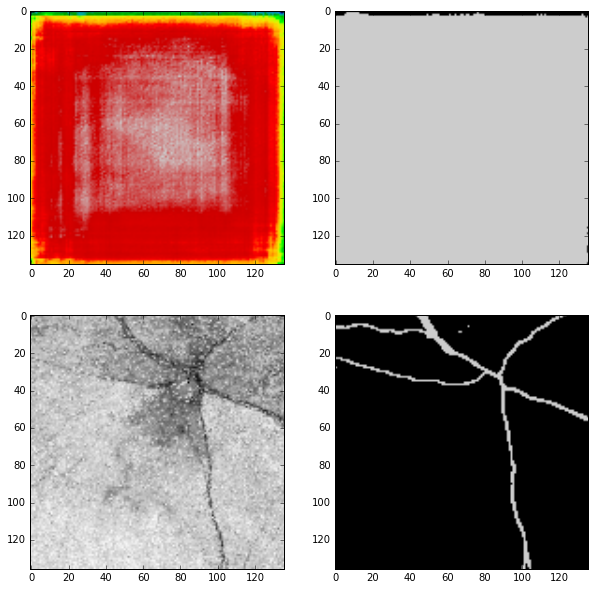

In [ ]:
training_outcomes = np.load('jaccard_20_epochs_using-x.npy')
for i in range(training_outcomes.shape[0]):
    training_outcomes[i,0,:,:] = (training_outcomes[i,0,:,:].min() - training_outcomes[i,0,:,:])/(training_outcomes[i,0,:,:].min()-training_outcomes[i,0,:,:].max())
plot_all(5,classType,0.5)
push('Images are ready','Go look!')

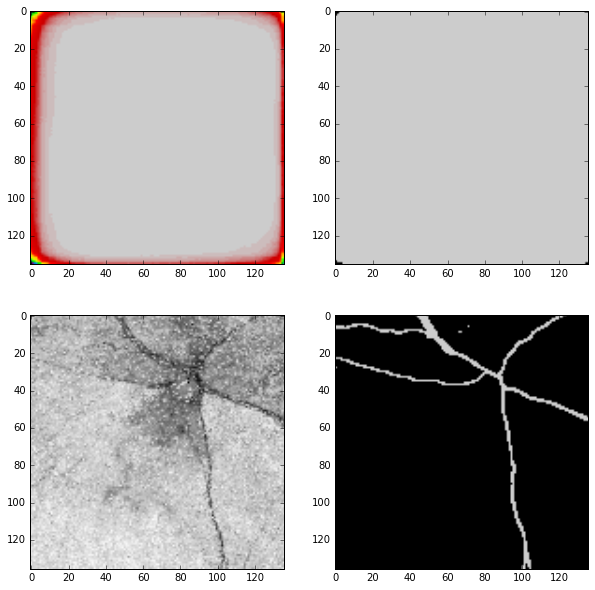

In [24]:
def plot_all(i,classType,threshold):
    fig = plt.figure(figsize=(10,10))

    ax1 = fig.add_subplot(221)
    ax1.imshow(training_outcomes[0,0,:,:],cmap='spectral')

    ax2 = fig.add_subplot(222)
    ax2.imshow(training_outcomes[0,0,:,:]>threshold,cmap='spectral')

    ax3 = fig.add_subplot(223)
    ax3.imshow(x[i,0,:,:],cmap='Greys')

    ax4 = fig.add_subplot(224)
    ax4.imshow(y[i,classType,:,:],cmap='spectral')
plot_all(5,classType,0.5)
#push('PICTURES!','The plots are ready')

### Defunct bits and pieces

In [ ]:
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], imgs.shape[1], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i, 0] = cv2.resize(imgs[i, 0], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
    return imgs_p